In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

In [ ]:
path = "drive/MyDrive/30_days_ML/data"

In [ ]:
# Loading data 
X_train = pd.read_csv(path+"/original/train.csv")
X_test = pd.read_csv(path+"/original/train.csv")

In [ ]:
X_train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,N,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,2,B,B,A,A,B,D,A,F,A,O,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,3,A,A,A,C,B,D,A,D,A,F,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,4,B,B,A,C,B,D,A,E,C,K,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,6,A,A,A,C,B,D,A,E,A,N,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


In [ ]:
class CustomModel(nn.Module):
  def __init__(self,emb_size,n_cont,p=0.5,h1=150,h2=100,h3=30,out_features = 1): 
    super().__init__()
    self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_size])
    self.dropout1 = nn.Dropout(p)
    self.dropout2 = nn.Dropout(p)
    self.dropout3 = nn.Dropout(p)

    n_emb = sum((nf for ni,nf in emb_size))

    self.bn_cont = nn.BatchNorm1d(n_cont)

    self.fc1 = nn.Linear(n_cont + n_emb,h1)
    self.bn1 = nn.BatchNorm1d(h1)
    self.fc2 = nn.Linear(h1,h2)
    self.bn2 = nn.BatchNorm1d(h2)
    self.fc3 = nn.Linear(h2,h3)
    self.bn3 = nn.BatchNorm1d(h3)
    self.out = nn.Linear(h3,out_features)
  
  def forward(self,x_cat,x_cont):
    embedding = []
    for i,e in enumerate(self.embeds):
      embedding.append(e(x_cat[:,i]))
    x = torch.cat(embedding,1)

    x_cont = self.bn_cont(x_cont)
    x = torch.cat([x,x_cont],1)

    x = F.relu(self.fc1(x))
    x = self.bn1(x)
    x = self.dropout1(x)

    x = F.relu(self.fc2(x))
    x = self.bn2(x)
    x = self.dropout2(x)

    x = F.relu(self.fc3(x))
    x = self.bn3(x)
    x = self.dropout3(x)

    x = self.out(x)

    return x
    
    

In [ ]:
class KaggleDataset(Dataset):
  def __init__(self):
    df = pd.read_csv(path+"/original/train.csv")

    categoricals = [item for item in df.columns if 'cat' in item]
    continuous = [item for item in df.columns if 'cont' in item]

    for cat in categoricals:
      df[cat] = df[cat].astype("category")
    
    cat0 = df["cat0"].cat.codes.values
    cat1 = df["cat1"].cat.codes.values
    cat2 = df["cat2"].cat.codes.values
    cat3 = df["cat3"].cat.codes.values
    cat4 = df["cat4"].cat.codes.values
    cat5 = df["cat5"].cat.codes.values
    cat6 = df["cat6"].cat.codes.values
    cat7 = df["cat7"].cat.codes.values
    cat8 = df["cat8"].cat.codes.values
    cat9 = df["cat9"].cat.codes.values

    categs = np.stack([cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9],1)
    self.categs = torch.tensor(categs, dtype = torch.int64)

    contins = np.stack([df[col].values for col in continuous],1)
    self.contins = torch.tensor(contins,dtype=torch.float)

    y = torch.tensor(df["target"].values,dtype=torch.float).reshape(-1,1)

    cat_size = [df[col].cat.categories.size for col in categoricals]
    self.emb_size = [(size,min(50,(size+1)//2)) for size in cat_size]

    data_size = len(y)
    valid_size = int(data_size * 0.2)

    self.cat_train = self.categs[:data_size-valid_size]
    self.cat_valid = self.categs[data_size-valid_size:]
    self.con_train = self.contins[:data_size-valid_size]
    self.con_valid = self.contins[data_size-valid_size:]
    self.y_train = y[:data_size-valid_size]
    self.y_valid = y[data_size-valid_size:]
    
    self.num = len(self.y_train)

  def __getitem__(self,index):
    return self.cat_train[index],self.con_train[index],self.y_train[index]

  def __len__(self):
    return self.num

In [ ]:
dataset = KaggleDataset()
total_samples = len(dataset)
print(total_samples)

240000


In [ ]:
import math
epochs = 10
batchsize = 12000
n_iterations = math.ceil(total_samples/batchsize)

In [ ]:
loss_list = []
trainloader = DataLoader(dataset = dataset,batch_size=batchsize,shuffle=True)

In [ ]:
dataset.emb_size

[(2, 1),
 (2, 1),
 (2, 1),
 (4, 2),
 (4, 2),
 (4, 2),
 (8, 4),
 (8, 4),
 (7, 4),
 (15, 8)]

In [ ]:
torch.manual_seed(3)
model = CustomModel(dataset.emb_size,14,p=0.1,h1=300,h2=150,h3=50,out_features=1)

torch.manual_seed(3)
model = CustomModel(dataset.emb_size,14,p=0.1,h1=300,h2=150,h3=50,out_features=1)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [ ]:
for epoch in range(epochs):
  for i, data in enumerate(trainloader):
    cat_train,con_train,labels = data

    y_pred = model(cat_train,con_train)
    loss = torch.sqrt(criterion(y_pred,labels))
    loss_list.append(loss.detach())

    print(f'Epoch{epoch+1}/{epochs} Iteration {i+1}/{n_iterations},Category{cat_train.shape}\
    Continusous{con_train.shape} Loss{loss.item():.3f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch1/10 Iteration 1/20,Categorytorch.Size([12000, 10])    Continusoustorch.Size([12000, 14]) Loss8.398
Epoch1/10 Iteration 2/20,Categorytorch.Size([12000, 10])    Continusoustorch.Size([12000, 14]) Loss8.389
Epoch1/10 Iteration 3/20,Categorytorch.Size([12000, 10])    Continusoustorch.Size([12000, 14]) Loss8.364
Epoch1/10 Iteration 4/20,Categorytorch.Size([12000, 10])    Continusoustorch.Size([12000, 14]) Loss8.283
Epoch1/10 Iteration 5/20,Categorytorch.Size([12000, 10])    Continusoustorch.Size([12000, 14]) Loss8.242
Epoch1/10 Iteration 6/20,Categorytorch.Size([12000, 10])    Continusoustorch.Size([12000, 14]) Loss8.192
Epoch1/10 Iteration 7/20,Categorytorch.Size([12000, 10])    Continusoustorch.Size([12000, 14]) Loss8.155
Epoch1/10 Iteration 8/20,Categorytorch.Size([12000, 10])    Continusoustorch.Size([12000, 14]) Loss8.111
Epoch1/10 Iteration 9/20,Categorytorch.Size([12000, 10])    Continusoustorch.Size([12000, 14]) Loss8.053
Epoch1/10 Iteration 10/20,Categorytorch.Size([12000, 10

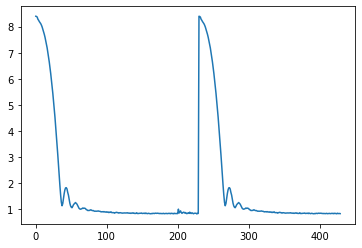

In [ ]:
plt.plot(loss_list)

In [ ]:
torch.save(model.state_dict(),"drive/MyDrive/30_days_ML/pytorchModel.pt")

In [ ]:
with torch.no_grad():
  y_val = model(dataset.cat_valid,dataset.con_valid)
  loss = torch.sqrt(criterion(y_val,dataset.y_valid))
  print(f'{loss.item():.3f}')

0.830


In [ ]:
print(f'Predicted_y True_t Error')
for i in range(30):
  error = np.abs(y_val[i].item()-dataset.y_valid[i].item())
  print(f'{i+1}.  {y_val[i].item():.3f}     {dataset.y_valid[i].item():.3f}  {error:.3f}')

Predicted_y True_t Error
1.  8.627     7.061  1.566
2.  7.939     7.224  0.715
3.  8.452     7.153  1.300
4.  8.546     7.365  1.180
5.  8.630     8.111  0.518
6.  7.930     9.116  1.186
7.  8.639     8.068  0.571
8.  8.504     8.026  0.478
9.  8.396     8.062  0.335
10.  8.572     7.541  1.031
11.  8.500     9.398  0.898
12.  8.111     8.614  0.503
13.  8.592     8.025  0.567
14.  7.875     8.075  0.200
15.  8.037     7.040  0.997
16.  8.439     8.292  0.147
17.  8.333     7.601  0.732
18.  8.642     7.355  1.287
19.  8.511     7.370  1.142
20.  8.251     8.268  0.017
21.  7.956     7.730  0.225
22.  7.102     8.341  1.240
23.  7.851     6.968  0.883
24.  8.596     7.022  1.573
25.  8.405     8.081  0.325
26.  8.061     7.852  0.209
27.  7.518     6.996  0.522
28.  8.196     8.474  0.278
29.  8.328     8.071  0.257
30.  8.157     8.092  0.065


In [ ]:
model.eval()


CustomModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(2, 1)
    (2): Embedding(2, 1)
    (3): Embedding(4, 2)
    (4): Embedding(4, 2)
    (5): Embedding(4, 2)
    (6): Embedding(8, 4)
    (7): Embedding(8, 4)
    (8): Embedding(7, 4)
    (9): Embedding(15, 8)
  )
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (bn_cont): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=43, out_features=300, bias=True)
  (bn1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=300, out_features=150, bias=True)
  (bn2): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=150, out_features=50, bias=True)
  (bn3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=50